<a href="https://colab.research.google.com/github/yshibata8513/kalman_filter/blob/master/0808_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import numpy as np

In [3]:
import sys
sys.path.append("./src")
from kf import *
from models import *

In [6]:
class PathPlantModel(BasePlantModel):
    def __init__(self):
        super().__init__(use_control=False,Q=torch.FloatTensor([[0.01,0,0,0,0]
                                                                ,[0.,0.01,0,0,0]
                                                                ,[0,0,0.01,0,0]
                                                                ,[0,0,0,0.01,0]
                                                                ,[0,0,0,0,0.1]]))
        self.dim_state = 5
        
    def forward(self,state,control,dt):
       
        theta = state[2]
        kappa = state[3]
        kappa_dot = state[4]
        
        dx = dt*torch.cos(theta)
        dy = dt*torch.sin(theta)
        dtheta = dt*kappa
        dkappa = dt*kappa_dot
        dkappa_dot = torch.zeros_like(dx)
        
        dstate = torch.cat([dx,dy,dtheta,dkappa,dkappa_dot],dim=-1).view(-1,1)
    
        return state + dstate
        

In [7]:
class ObserverXY(BaseObserverModel):
    def __init__(self,R=torch.FloatTensor([[0.1,0],[0,0.1]])):
        super().__init__(R)
        self.dim_state = 5
        self.dim_obs = 2
        self._H = torch.FloatTensor([[1,0,0,0,0],[0,1,0,0,0]])

    @property
    def R(self):
        return self._R
    
    def forward(self,state):
        return self._H@state

In [8]:
class ObserverXYK(BaseObserverModel):
    def __init__(self,R=torch.FloatTensor([[0.1,0,0],
                                           [0,0.1,0],
                                           [0,0,0.01]])):
        super().__init__(R)
        self.dim_state = 5
        self.dim_obs = 2
        self._H = torch.FloatTensor([[1,0,0,0,0],
                                     [0,1,0,0,0],
                                     [0,0,0,1,0]])

    @property
    def R(self):
        return self._R
    
    def forward(self,state):
        return self._H@state

In [11]:
def CreatePathFromKappaDot(dss,kappa_dot,x0=0,y0=0,theta0=0,kappa0=0):
    x0 = torch.Tensor([x0]).view(1)
    y0 = torch.Tensor([y0]).view(1)
    theta0 = torch.Tensor([theta0]).view(1)
    kappa0 = torch.Tensor([kappa0]).view(1)
    
    
    xs = [x0]
    ys = [y0]
    thetas = [theta0]
    kappas = [kappa0]
    x = x0
    y = y0
    theta = theta0
    kappa = kappa0
    for ds,kd in zip(dss,kappa_dot):
        x = x + ds*torch.cos(theta)
        y = y + ds*torch.sin(theta)
        theta = theta + ds*kappa
        kappa = kappa + ds*kd
        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        kappas.append(kappa)
    xs = torch.Tensor(xs)
    ys = torch.Tensor(ys)
    thetas = torch.Tensor(thetas)
    kappas = torch.Tensor(kappas)
    
    return xs,ys,thetas,kappas

In [24]:
N = 100

dts = torch.ones(N-1)*0.1
kappa_dot = torch.ones(N-1)*0.03

xs,ys,thetas,kappas = CreatePathFromKappaDot(dts,kappa_dot) 

nx= torch.randn(N)*0.1
ny= torch.randn(N)*0.1
nk = torch.randn(N)*0.01
observations = torch.stack([xs+nx,ys+ny,kappas+nk],dim=-1)
observations = observations[1:]
state0 = torch.Tensor([xs[0],ys[0],thetas[0],kappas[0],kappa_dot[0]]).view(-1,1)

In [25]:
P0 = torch.FloatTensor([ [0.1,0  ,0  ,0  ,0]
                        ,[0  ,0.1,0  ,0  ,0]
                        ,[0  ,0  ,0.3,0  ,0]
                        ,[0  ,0  ,0  ,0.3,0]
                        ,[0  ,0  ,0  ,0  ,0.3]])

In [27]:
s0 = state0
p_model = PathPlantModel()
o_model = ObserverXYK()
kfc = KalmanFilterCalculator(p_model,o_model)
kf = KalamanFilter(kfc)


In [28]:
Ss_p,Ps_p,Ss_f,Ps_f = kf.filtering(s0,P0,dts,observations,init_obs=False)

Ss_s,Ps_s =  kf.smoothing(dts=dts,Ss_p=Ss_p,Ps_p=Ps_p,Ss_f=Ss_f,Ps_f=Ps_f)


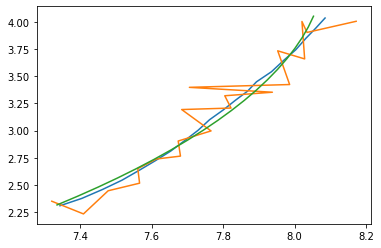

In [29]:
import matplotlib.pyplot as plt

plt.plot(Ss_s[-20:,0],Ss_s[-20:,1])
#plt.plot(Ss_f[-20:,0],Ss_f[-20:,1])
plt.plot(observations[-20:,0],observations[-20:,1])
#plt.plot(Ss_s[1:21,0])
plt.plot(xs[-20:],ys[-20:])

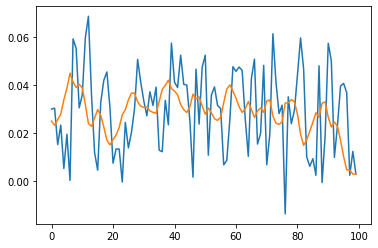

In [30]:
plt.plot(Ss_f[...,-1])
plt.plot(Ss_s[...,-1])

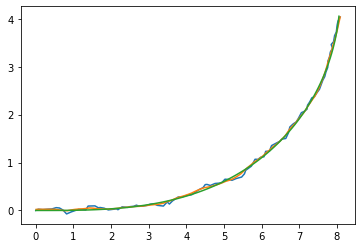

In [32]:
plt.plot(Ss_f[...,0],Ss_f[...,1])
plt.plot(Ss_s[...,0],Ss_s[...,1])

plt.plot(xs,ys)

In [19]:

#plt.plot(observations[:20])

In [20]:
#_Ss_p = torch.cat(Ss_p[1:],dim=0)
plt.plot(_Ss_p[1:20,0])
plt.plot(_Ss_f[1:20,0])
plt.plot(_Ss_a[1:20])
plt.plot(observations[:19])

NameError: name '_Ss_p' is not defined

In [ ]:
# Ss_p = []
# Ss_f = []
# Ps_p = []
# Ps_f = []
# p = P0
# s = s0
# for t in range(100-1):
#     s,p = kf._prediction(s.view(2,1),c0.view(1,1),dt,p)
#     Ss_p.append(s.data.clone())
#     Ps_p.append(p.data.clone())
    
#     s,p = kf._filtering(s.view(2,1),c0.view(1,1),dt,p,states[t+1,0].view(1,1))
#     Ss_f.append(s.data.clone())
#     Ps_f.append(p.data.clone())
    
# len(Ss_p),len(Ss_f),len(Ps_p),len(Ps_f)


In [ ]:
Ss_p[1].size(),Ss_p[2].size(),Ss_f[0].size(),Ss_f[1].size()

In [ ]:
s = Ss_f[-1]
p = Ps_f[-1]
Ss_s = [Ss_f[-1]]
Ps_s = [Ps_f[-1]]

for _t in range(99):
    t = 99 - (_t )

    

    s_p = Ss_p[t]
    s_f = Ss_f[t-1]
    P_p = Ps_p[t]
    P_f = Ps_f[t-1]
    s,p = kfc._smoothing(s_p,s_f,s,c0.view(1,1),P_p,P_f,p,dt)
    Ss_s.append(s.data.clone())


    Ps_s.append(p.data.clone())



In [ ]:
#_Ss_f = torch.cat([s.view(1,-1) for s in Ss_f],dim=0)


In [ ]:
plt.plot(_Ss_f[:20,0])
plt.plot(_Ss_s[:20,0]),len(_Ss_f),len(_Ss_s)

In [ ]:
_Ss_s = torch.stack(Ss_s,dim=0).view(-1,2).data.numpy()[::-1].copy()
_Ss_f = torch.stack(Ss_f,dim=0)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(_Ss_s[:,0][:10])
plt.plot(_Ss_f[:,0][:10])
plt.plot(states[:,0][1:11])

In [ ]:
len(_Ss_s)